In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display, Math, Latex
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime
InteractiveShell.ast_node_interactivity = "all"

from models.pv_model import PVModel
from models.load import Consumer, hour_loads
from models.storage import StorageModel

%matplotlib inline

Text(0.5, 0, 'hour [00:00 - 23:00]')

Text(0, 0.5, 'load coefficient')

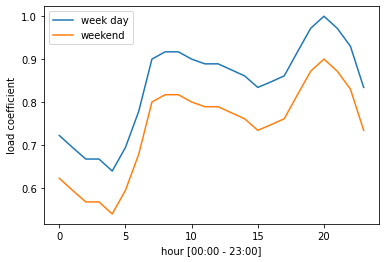

In [2]:
plt.plot(hour_loads.keys(), hour_loads.values());
plt.plot(hour_loads.keys(), np.array(list(hour_loads.values()))-0.1);
plt.legend(['week day', 'weekend']);
plt.xlabel('hour [00:00 - 23:00]');
plt.ylabel('load coefficient')

In [3]:
unit_cons_load = pd.DataFrame()

unit_cons_load['appliance'] = ['light bulb', 
                               'computer',
                               'laptop',
                               'television',
                               'phone charger',
                               'fridge',
                               'washing machine']
unit_cons_load['quantity'] = [5, 1, 1, 1, 2, 1, 1]
unit_cons_load['hours_per_day'] = [6, 10, 10, 10, 4, 3, 3]
unit_cons_load['power_rating'] = [20, 250, 40, 30, 5, 150, 125]
unit_cons_load[
    'total_per_day'] = unit_cons_load.hours_per_day*unit_cons_load.quantity*unit_cons_load.power_rating

unit_cons_load

,appliance,quantity,hours_per_day,power_rating,total_per_day
0,light bulb,5,6,20,600
1,computer,1,10,250,2500
2,laptop,1,10,40,400
3,television,1,10,30,300
4,phone charger,2,4,5,40
5,fridge,1,3,150,450
6,washing machine,1,3,125,375


### Daily household load (Wh)

In [4]:
np.sum(unit_cons_load['total_per_day'])

4665

In [5]:
s_load = 2.5 # starting power coefficient
max_consumer_load = s_load*unit_cons_load.power_rating.sum()
min_consumer_load = s_load*unit_cons_load[unit_cons_load.appliance=='fridge'].power_rating.values[0]
mean_consumer_load = s_load*np.sum(
    unit_cons_load.hours_per_day*unit_cons_load.quantity*unit_cons_load.power_rating)/24
std_consumer_load = s_load*(max_consumer_load - min_consumer_load) / 12

max_consumer_load, min_consumer_load, mean_consumer_load, std_consumer_load

(1550.0, 375.0, 485.9375, 244.79166666666666)

### Daily 100 households load (kWh)

In [6]:
np.sum(unit_cons_load['total_per_day'])*100/1000

466.5

### Hourly 100 households load, rough estimate (kWh)

In [7]:
h_load = mean_consumer_load*100
h_load

48593.75

### Storage system capacity

In [8]:
display(Math(r'C_b = \frac{ W_d * T_{out}}{\eta_{b} * DoD }'))

<IPython.core.display.Math object>

In [9]:
consumer = Consumer(
    min_load=min_consumer_load,
    max_load=max_consumer_load,
    avg_load=mean_consumer_load,
    std=std_consumer_load,)

In [10]:
eta_r = 0.19
eta_tr = 0.25
NOCT = 45

module_area = (156*156)/1000
battery_capacity = 160e3

n_panels = [400, 425, 450, 475, 500, 525, 550]

In [11]:
df = pd.read_csv('solar_rad.csv')
df_de = pd.read_csv('solar_rad_de.csv')
df.loc[:, 'time'] = pd.to_datetime(df.time)
df_de.loc[:, 'time'] = pd.to_datetime(df_de.time)
df.head()

,time,temperature,global_radiation
0,2005-01-01 06:10:00,0.90,13.63
1,2005-01-01 07:10:00,1.42,81.08
2,2005-01-01 08:10:00,1.95,60.02
3,2005-01-02 06:10:00,0.92,13.59
4,2005-01-02 07:10:00,1.68,186.08


In [12]:
df.tail()

,time,temperature,global_radiation
39035,2016-12-31 09:10:00,-0.42,914.28
39036,2016-12-31 10:10:00,0.05,815.20
39037,2016-12-31 11:10:00,0.52,643.91
39038,2016-12-31 12:10:00,0.98,822.75
39039,2016-12-31 13:10:00,-1.04,493.15


In [13]:
ref_temp = df.temperature.values[0]
module_nums = []
en_surplus = []
en_deficit = []
res_df = pd.DataFrame()
num_consumers = 100

if not os.path.exists('simulation_results.csv'):
    for num in n_panels:
        battery = StorageModel()
        model = PVModel(num, module_area)
        p_bar = tqdm(df.iterrows(), total=df.shape[0])
        for idx, row in p_bar:
            hour = row.time.hour
            temperature, radiation = row.temperature, row.global_radiation

            state = model.calc_state(radiation, temperature, ref_temp)
            load = 0
            # draw sample for each consumer, this will 
            # be different how it is supposed to be 
            for i in range(num_consumers):
                load += consumer.load_grid(hour)
            
            ref_temp = temperature
            stored = battery.process_load(load, state)
            module_nums.append(num)

            en_surplus.append((num, stored, state-load))
            
            record = {
                'date': row.time,
                'load': load,
                'n_panels': num,
                'battery_energy': stored,
                'temperature': ref_temp,
                'irradiation': radiation,
                'state': state,
            }
            
            if idx%50 == 0:
                p_bar.set_postfix(
                    {'load': round(load/1000, 2),
                     'state': round(state/1000, 2),
                     'stored': round(stored/1000, 2)})

            res_df = res_df.append(record, ignore_index=True)
            
    res_df.to_csv('simulation_results.csv', index=False)
else:
    res_df = pd.read_csv('simulation_results.csv')
    # en_surplus.append((num, stored, state-load))
    # en_surplus = (res_df.state - res_df.load).tolist()
    for idx, row in res_df.iterrows():
        num, stored = row['n_panels'], row['battery_energy']
        state, load = row['state'], row['load']
        en_surplus.append((num, stored, state-load))
        module_nums.append(num)

In [14]:
res_df

,battery_energy,date,irradiation,load,n_panels,state,temperature
0,89239.846575,2005-01-01 06:10:00,13.63,132102.447345,400.0,6302.293920,0.90
1,64000.000000,2005-01-01 07:10:00,81.08,130343.569832,400.0,37392.620474,1.42
2,64000.000000,2005-01-01 08:10:00,60.02,138166.461975,400.0,27678.744118,1.95
3,64000.000000,2005-01-02 06:10:00,13.59,132715.237043,400.0,6316.160123,0.92
4,64000.000000,2005-01-02 07:10:00,186.08,140328.828020,400.0,85713.461144,1.68
...,...,...,...,...,...,...,...
273275,307200.000000,2016-12-31 09:10:00,914.28,140073.816924,550.0,577704.243314,-0.42
273276,307200.000000,2016-12-31 10:10:00,815.20,141101.533514,550.0,517068.252970,0.05
273277,307200.000000,2016-12-31 11:10:00,643.91,127811.397616,550.0,408421.760022,0.52
273278,307200.000000,2016-12-31 12:10:00,822.75,140669.977544,550.0,521883.250896,0.98


In [15]:
vis_df = res_df[res_df.n_panels == 500]
vis_df = vis_df[vis_df.index%50 == 0]

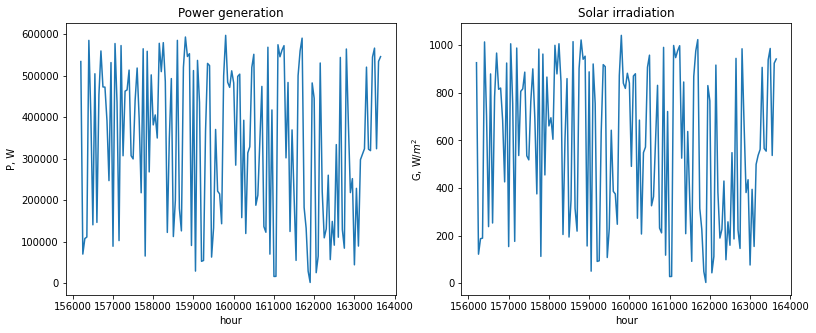

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
vis_df[:150].state.plot(ax=ax[0]);
ax[0].set_title('Power generation');
ax[0].set_ylabel('P, W');
ax[0].set_xlabel('hour');

vis_df[:150].irradiation.plot(ax=ax[1]);
ax[1].set_title('Solar irradiation');
ax[1].set_ylabel('G, W/$m^2$');
ax[1].set_xlabel('hour');
plt.savefig('power_gen_irrad.png');

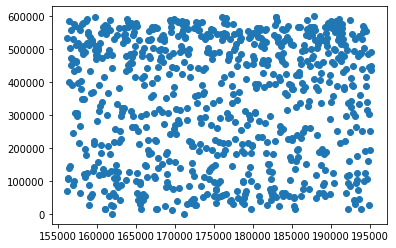

In [17]:
plt.scatter(vis_df.index, vis_df.state)

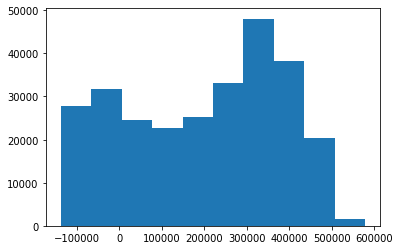

In [18]:
plt.hist([x[2] for x in en_surplus]);

In [19]:
module_nums = np.array(module_nums)

In [20]:
np.quantile(module_nums, 0.75)

525.0

In [21]:
len(en_surplus)

273280

In [22]:
candidates = [425,  450,  475,  500,  525,  550]

for cand in candidates:
    print(f'{cand} panels: {np.mean([x[-1] for x in en_surplus if x[0]==cand])} mean surplus')
    print(f'{cand} panels: {np.median([x[-1] for x in en_surplus if x[0]==cand])} median surplus')
    print(f'{cand} panels: {np.std([x[-1] for x in en_surplus if x[0]==cand])} standard deviation surplus')
    print('-'*10)

425 panels: 164600.2088164811 mean surplus
425 panels: 201181.48644581897 median surplus
425 panels: 158266.4181898932 standard deviation surplus
----------
450 panels: 182085.23504131055 mean surplus
450 panels: 220839.51242485933 median surplus
450 panels: 167632.76337213974 standard deviation surplus
----------
475 panels: 199525.5504058027 mean surplus
475 panels: 240377.1513581315 median surplus
475 panels: 176933.3588791223 standard deviation surplus
----------
500 panels: 217012.00536059428 mean surplus
500 panels: 260179.90367392416 median surplus
500 panels: 186328.19021353123 standard deviation surplus
----------
525 panels: 234501.80986721764 mean surplus
525 panels: 279271.24370304187 median surplus
525 panels: 195739.57057470453 standard deviation surplus
----------
550 panels: 251977.2875828964 mean surplus
550 panels: 299013.65908367885 median surplus
550 panels: 205094.65913359466 standard deviation surplus
----------


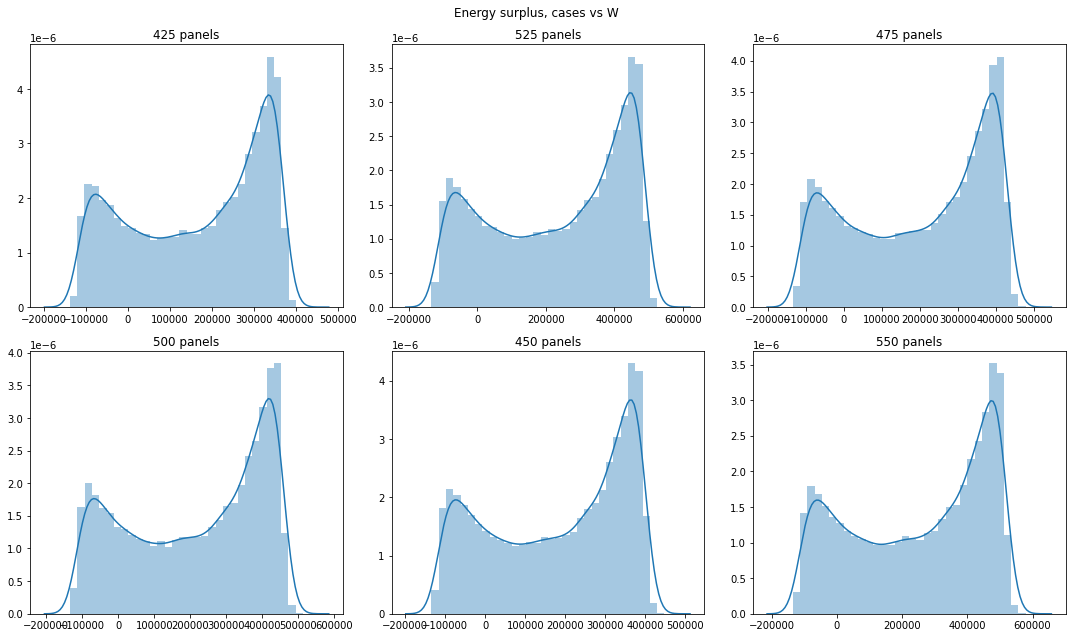

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i, cand in enumerate(candidates):
    sns.distplot(np.array(([x[-1] for x in en_surplus if x[0]==cand])), ax=ax[i%2][i%3]);
    ax[i%2][i%3].set_title(f'{cand} panels');

fig.suptitle('Energy surplus, cases vs W');
plt.tight_layout();

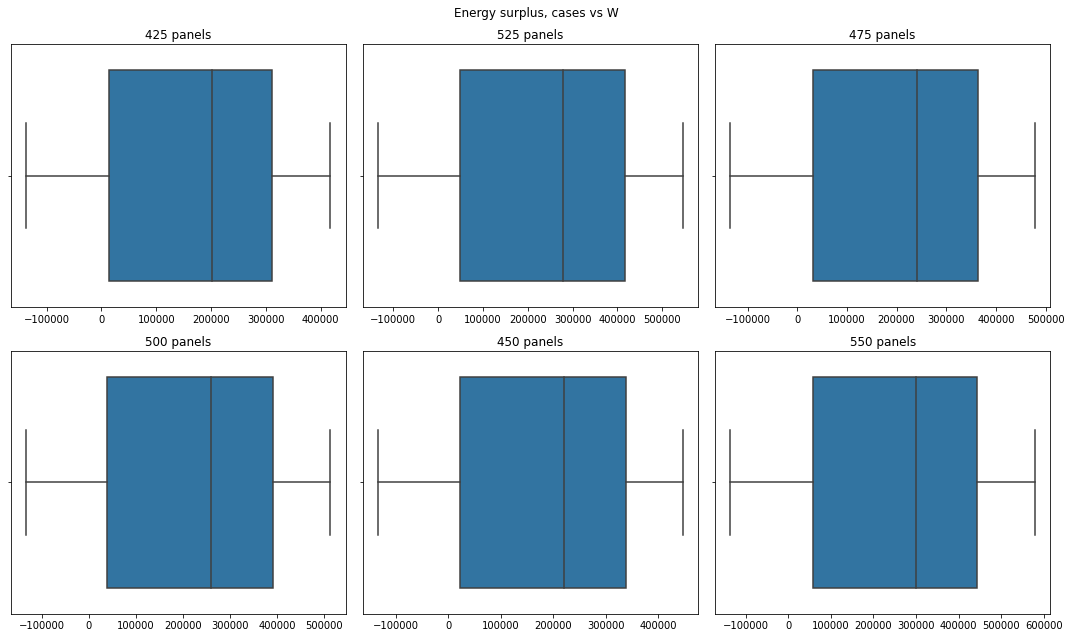

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i, cand in enumerate(candidates):
    sns.boxplot(np.array(([x[-1] for x in en_surplus if x[0]==cand])), ax=ax[i%2][i%3]);
    ax[i%2][i%3].set_title(f'{cand} panels');

fig.suptitle('Energy surplus, cases vs W');
plt.tight_layout();

In [25]:
len(en_surplus), len(en_deficit)

(273280, 0)

In [26]:
len([x for x in en_surplus if x[1]>0]), len([x for x in en_deficit if x[1]<=battery_capacity*0.25])

(273280, 0)

In [27]:
np.sum([x for x in en_surplus if x[1]>0])/1e7, np.sum([x for x in en_deficit if x[1]<=battery_capacity*0.25])/1e7

(12910.126252142849, 0.0)

### Ukraine vs Germany

In [28]:
n_panels = [500]
dfs = []

for dataframe in [df, df_de]:
    ref_temp = dataframe.temperature.values[0]
    res_dataframe = pd.DataFrame()
    en_surplus = []
    
    for num in n_panels:
        battery = StorageModel()
        model = PVModel(num, module_area)
        p_bar = tqdm(dataframe.iterrows(), total=dataframe.shape[0])
        for idx, row in p_bar:
            hour = row.time.hour
            temperature, radiation = row.temperature, row.global_radiation

            state = model.calc_state(radiation, temperature, ref_temp)
            load = 0
            for i in range(num_consumers):
                load += consumer.load_grid(hour)
                
            ref_temp = temperature
            stored = battery.process_load(load, state)

            en_surplus.append((num, stored, state-load))
            
            record = {
                'date': row.time,
                'load': load,
                'n_panels': num,
                'battery_energy': stored,
                'temperature': ref_temp,
                'irradiation': radiation,
                'state': state,
            }
            
            if idx%50 == 0:
                p_bar.set_postfix(
                    {'load': round(load/1000, 2),
                     'state': round(state/1000, 2),
                     'stored': round(stored/1000, 2)})

            res_dataframe = res_dataframe.append(record, ignore_index=True)
    dfs.append(res_dataframe)

In [29]:
ukr_results, german_results = dfs
ukr_results

,battery_energy,date,irradiation,load,n_panels,state,temperature
0,94314.559177,2005-01-01 06:10:00,13.63,128603.308223,500.0,7877.867400,0.90
1,64000.000000,2005-01-01 07:10:00,81.08,133924.053699,500.0,46740.775592,1.42
2,64000.000000,2005-01-01 08:10:00,60.02,136763.014009,500.0,34598.430147,1.95
3,64000.000000,2005-01-02 06:10:00,13.59,129100.062543,500.0,7895.200153,0.92
4,64000.000000,2005-01-02 07:10:00,186.08,134388.163004,500.0,107141.826430,1.68
...,...,...,...,...,...,...,...
39035,307200.000000,2016-12-31 09:10:00,914.28,132509.841770,500.0,525185.675740,-0.42
39036,307200.000000,2016-12-31 10:10:00,815.20,138550.587455,500.0,470062.048154,0.05
39037,307200.000000,2016-12-31 11:10:00,643.91,128567.808383,500.0,371292.509111,0.52
39038,307200.000000,2016-12-31 12:10:00,822.75,124259.477529,500.0,474439.318997,0.98


In [30]:
results = german_results.merge(
    ukr_results, on='date', how='inner', suffixes=['_de', '_ukr'])

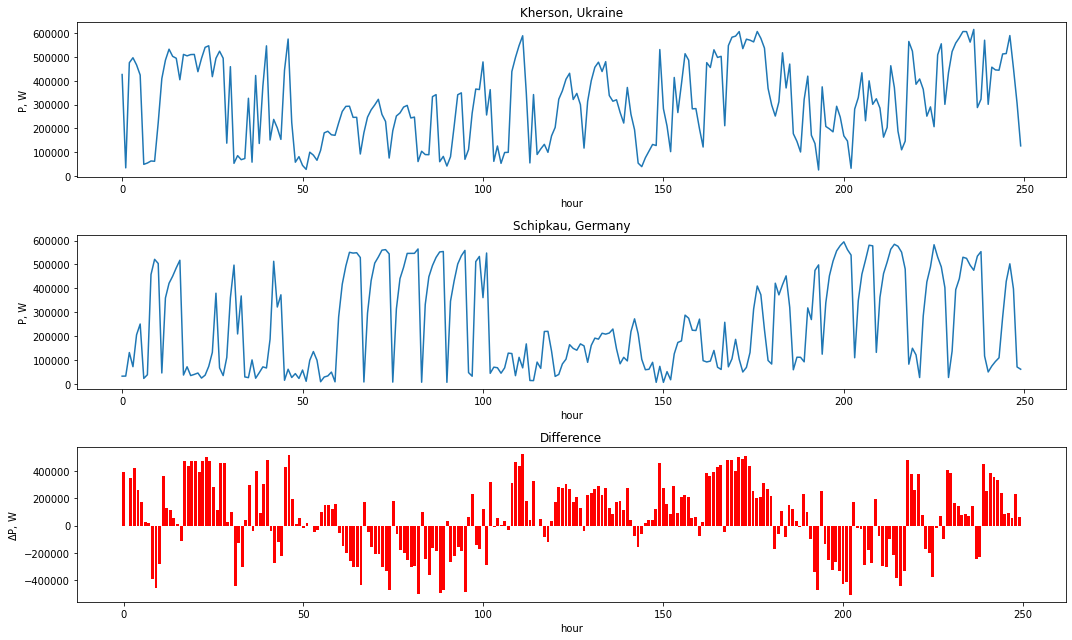

In [31]:
sample_size = 250
fig, ax = plt.subplots(3,1, figsize=(15, 9))
residuals = results[:sample_size].state_ukr - results[:sample_size].state_de

ax[0].plot(results[:sample_size].state_ukr);
ax[0].set_title('Kherson, Ukraine');
ax[0].set_xlabel('hour');
ax[0].set_ylabel('P, W');

ax[1].plot(results[:sample_size].state_de);
ax[1].set_title('Schipkau, Germany');
ax[1].set_xlabel('hour');
ax[1].set_ylabel('P, W');

ax[2].bar(results[:sample_size].index, residuals, color='red');
ax[2].set_title('Difference');
ax[2].set_xlabel('hour');
ax[2].set_ylabel('$\Delta$P, W');

plt.tight_layout();
plt.savefig('fig123.png');

In [32]:
residuals.mean()

57057.477731977604